# Buckling and post-buckling of an hyperelastic beam

In [1]:
from dolfin import *
from mshr import *
import ufl 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from slepc4py import SLEPc
from slepc_eigensolver import EigenSolver

%matplotlib inline
plt.style.use('seaborn-notebook')

## Hyperelastic problem formulation

We define the hyperelastic problem for a rectangular slab under its own weight, as done in other notebook.
We set also a standard newton solver

In [2]:
# Create mesh and define boundaries fof BCs
nu = 0.3
nx = 40
ny = 5 
Lx = 1 
Ly = .1
degree = 2
mesh = dolfin.RectangleMesh(dolfin.Point(0, 0), dolfin.Point(Lx, Ly), nx, ny)
left = dolfin.CompiledSubDomain("near(x[0], 0) && on_boundary")
right = dolfin.CompiledSubDomain("near(x[0], Lx) && on_boundary", Lx=Lx)
boundary_markers = dolfin.MeshFunction("size_t", mesh, dim=1, value=0)
left_index = 1
right_index = 2
left.mark(boundary_markers, left_index)
right.mark(boundary_markers, right_index)
ds = dolfin.ds(domain=mesh,subdomain_data=boundary_markers)
dx = dolfin.dx(domain=mesh)

V_element = dolfin.VectorElement('CG', ufl.triangle, degree=degree, dim=2) 
V = dolfin.FunctionSpace(mesh, V_element)
u = dolfin.Function(V, name="u")

I = ufl.Identity(2)
F = ufl.variable(I + ufl.grad(u))  
C = F.T*F                   
Ic = ufl.tr(C)
J  = ufl.det(F)
E = 1/2*(C-I)
Y = 1.e3
mu, lmbda = dolfin.Constant(Y/(2*(1 + nu))), dolfin.Constant(Y*nu/((1 + nu)*(1 - 2*nu)))
lmbda = 2*lmbda*mu/(lmbda + 2*mu) 
psi = (mu/2)*(Ic - 2) - mu*ufl.ln(J) + (lmbda/2)*(ufl.ln(J))**2

rho_g =  Y * Ly**2 / 12 / Lx**3
b0 = dolfin.Expression(("-t*rho_g*cos(alpha)", "t*rho_g*sin(alpha)"),
                           t=0, alpha=0, rho_g=rho_g, degree=0)  
g0 = mu*dolfin.Constant((0.0,0.0)) 

potential_energy = psi*dx - ufl.dot(b0, u)*dx - ufl.dot(g0, u)*ds(2)
residual = ufl.derivative(potential_energy, u, dolfin.TestFunction(V))
jacobian = ufl.derivative(residual, u, dolfin.TrialFunction(V))
bcs = [dolfin.DirichletBC(V, (0., 0.), left)]
problem = dolfin.NonlinearVariationalProblem(residual, u, bcs=bcs, J=jacobian)
solver = dolfin.NonlinearVariationalSolver(problem)


## How to compute the eigenvalues of the eigenvectors of the Hessian matrix

The stability depends on the minimal eigenvalue of the Hessian matrix, obtained by assembling the bilinear form `ddE` above (the second derivative of the energy). 

Here, as an example, we calculate them for the undeformed configuration  `u=0`.

To this end we use the class `EigenSolver` of the module `slepc_eigensolver`.

---- setting additional slepc options -----
     eps_max_it : 100
Solution method: krylovschur, stopping condition: tol=1e-08, maxit=100
Number of converged/requested eigenvalues with 1 iterations  : 8/6
The smallest eigenvalues are 
 [1.12673012e-03 4.04623992e-02 2.77596897e-01 2.80055530e-01
 9.22464698e-01 2.14021020e+00 2.49479913e+00 4.04690493e+00]
saved eigenvectors in  results/eigenvectors-0.pvd


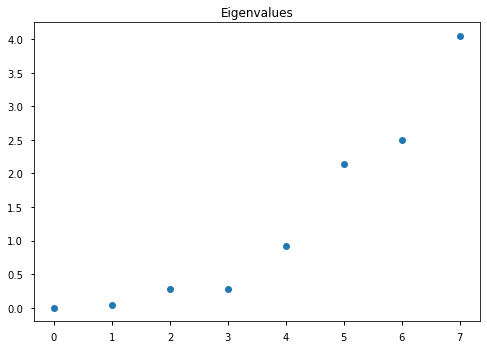

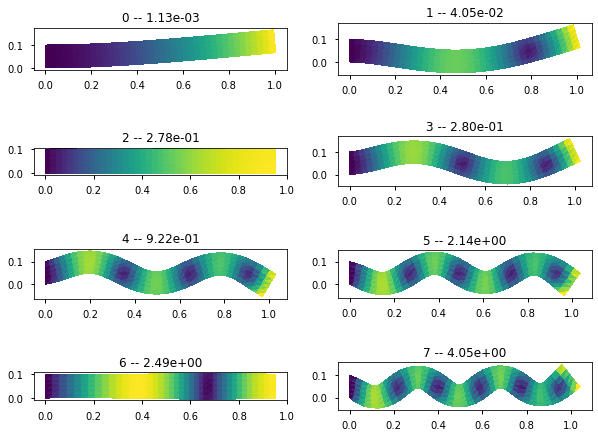

In [3]:
u.assign(interpolate(Constant(("0","0")),V))
neig = 6
eig_solver = EigenSolver(jacobian,u,bcs=bcs)
ncv, it = eig_solver.solve(neig,verbose=True)
eigenvalues, [eigenvectors_real, eigenvectors_im] = eig_solver.get_eigenpairs(ncv)
print("The smallest eigenvalues are \n", eigenvalues.real)

# save the eigenvectors tp a file that can be opened in paraview
eig_solver.save_eigenvectors(ncv, 'results/eigenvectors-0.pvd')

# plot the eigenvalues
plt.figure()
plt.plot(eigenvalues.real,'o')
plt.title("Eigenvalues")

# plot the eigenvectors
figure = plt.figure(figsize = (10, 10))
for i in range(ncv):
    plt.subplot(int(ncv/2+1),2,i+1)
    dolfin.plot(eigenvectors_real[i],mode='displacement')
    plt.title("{:d} -- {:2.2e}".format(i,eigenvalues[i].real))

## Nonlinear quasi-static evolution with stability check

We compute here a quasi-static evolution obtained when increasing the loading parameter `t`.

At each time step:
    
    - We compute the solution using a Newton solver, using the solution at the previous time-step as initial guess
    
    - We check the stability of the solution, by computing the smallest eigenvalue of the second derivative of the energy

    For the stability check, we define the following function returning the smallest eigenvalue of a bilinear form with given Dirichlet boundary conditions

In [5]:
def stability_monitor(ddE, u, bcs, neig=2,verbose=True):
    eig_solver = EigenSolver(ddE, u, bcs=bcs)
    ncv, it = eig_solver.solve(neig,verbose=verbose) 
    eigenvalues, [eigenvectors_real, eigenvectors_im] = eig_solver.get_eigenpairs(ncv)
    min_eig = min(eigenvalues.real)
    return min_eig
    
stability_monitor(jacobian, u, bcs, neig=2)


---- setting additional slepc options -----
     eps_max_it : 100
Solution method: krylovschur, stopping condition: tol=1e-08, maxit=100
Number of converged/requested eigenvalues with 1 iterations  : 6/2


0.0011267301172515687

Text(0, 0.5, 'smallest eigenvalue')

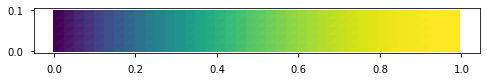

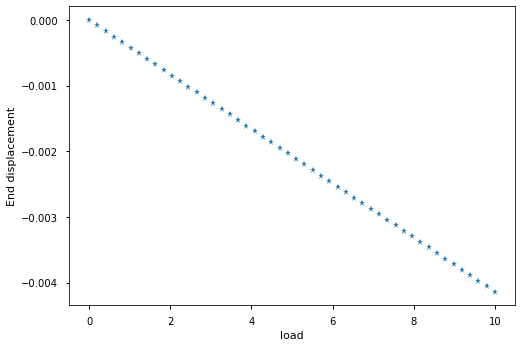

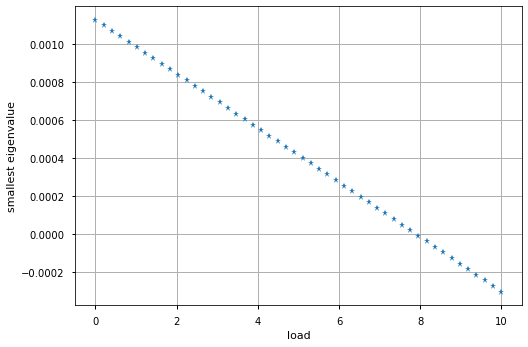

In [9]:
u.assign(Constant((0., 0.)))
loads = np.linspace(0.0, 10, 50)
forces = 0. * loads
displ = 0. * loads
min_eig = 0. * loads
u.rename("u","u")
file_u = File("results/nonlinear_compression.pvd");
for (i,t) in enumerate(loads):
    b0.t = t 
    # solve the problem
    solver.solve()
    # compute the smallest eigenvalue
    min_eig[i] = stability_monitor(jacobian, u, bcs, neig=2,verbose=False)
    # force and end displacement
    displ[i] = assemble(u[0]*ds(2))/Ly # average displacement of the right end
    file_u << (u,t)
plt.figure(0)
plot(u, mode = "displacement")
plt.figure(1)
plt.plot(loads,displ,"*")
plt.xlabel("load")
plt.ylabel("End displacement")
plt.figure(2)
plt.plot(loads,min_eig,"*")
plt.grid()
plt.xlabel("load")
plt.ylabel("smallest eigenvalue")